In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Text(0, 0.5, 'pz (keV/c)')

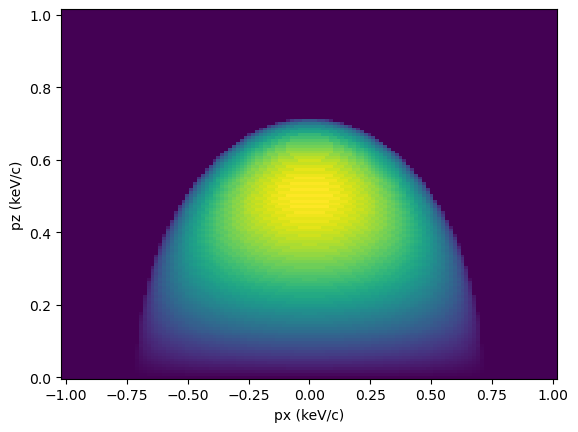

In [6]:
def fermi_dirac(e, mu, t, t_cutoff=1e-3):
    kb = 8.617333262e-5  # eV/K from CODATA recommendation
    return 1/(1 + np.exp(np.clip((e - mu)/(kb*np.clip(t, t_cutoff, None)), -256, 256)))


def ds_pdf_internal(px, py, pz, fermi_energy, t, photon_energy, workfun):
    mc2 = 511e3
    e = (px**2 + py**2 + pz**2)/2/mc2
    p_excite = (1 - fermi_dirac(e + photon_energy, fermi_energy, t))*fermi_dirac(e, fermi_energy, t)
    p_transport = pz > 0
    p_escape = pz**2/2/mc2 + photon_energy >= fermi_energy + workfun
    return p_excite*p_transport*p_escape


def transform(px, py, pz, fermi_energy, photon_energy, workfun):
    mc2 = 511e3
    a = np.sqrt(1 - photon_energy/((px**2 + py**2 + pz**2)/2/mc2 + fermi_energy + workfun))
    qx = px*a
    qy = py*a
    qz = np.sqrt(pz**2 + 2*mc2*(fermi_energy + workfun))*a
    return qx, qy, qz


def jacobian_factor(px, py, pz, fermi_energy, photon_energy, workfun):
    mc2 = 511e3
    num = pz*np.sqrt(px**2 + py**2 + pz**2 + 2*mc2*(fermi_energy + workfun - photon_energy))
    den = np.sqrt((pz**2 + 2*mc2*(fermi_energy + workfun))*(px**2 + py**2 + pz**2 + 2*mc2*(fermi_energy + workfun)))
    return num/den


def ds_pdf_external(px, py, pz, fermi_energy, t, photon_energy, workfun):
    a = jacobian_factor(px, py, pz, fermi_energy, photon_energy, workfun)
    return a*ds_pdf_internal(*transform(px, py, pz, fermi_energy, photon_energy, workfun), fermi_energy, t, photon_energy, workfun)


fermi_energy = 6
t = 0
photon_energy = 2.5
workfun = 2
mc2 = 511e3

maxp = np.sqrt(2*mc2*(1))
px, py, pz = np.mgrid[-maxp:maxp:128j, -maxp:maxp:128j, 0:maxp:128j]

rho = np.sum(ds_pdf_external(px, py, pz, fermi_energy, t, photon_energy, workfun), axis=1)
plt.pcolormesh(1e-3*px[:, 0, :], 1e-3*pz[:, 0, :], rho)
plt.xlabel("px (keV/c)")
plt.ylabel('pz (keV/c)')